In [1]:
! pip install pandas
! pip install boto3
! pip install watchtower
! pip install s3fs==0.4.2
! pip install pyathena
! pip install matplotlib
! pip install scipy
! pip install ipywidgets
! pip install scikit-learn

! conda install -c conda-forge --yes implicit 

! pip install --upgrade jupyter_client # useful to make ipywidgets work properly when fitting data with implicit

# pip install git+https://gitlab.com/cloena/cloena-aws-tools.git

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.4.0
    Uninstalling s3fs-0.4.0:
      Successfully uninstalled s3fs-0.4.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 53 kB 3.1 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrad

In [2]:
import pandas as pd

import s3fs

import pickle

import implicit

from aws_tools import athena_tools, s3_tools

import matplotlib

import re

import scipy

from ipywidgets import FloatProgress

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')


In [3]:
_v = '_v0.2'

In [4]:
data = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/historicalviews'+_v+'.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,ID_USER,TYPE_SLOT,TYPE_ASSET,VIEW_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING
0,BBEU32029145,Feature,episode,2019-06-29 16:09:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
1,BBEU29937057,Feature,episode,2019-06-29 08:27:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
2,BBEU33421092,Feature,episode,2019-06-29 18:38:24,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
3,BBEU18833349,Feature,episode,2019-06-29 16:22:29,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
4,BBEU27799836,Feature,episode,2019-06-29 08:11:53,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u


In [6]:
DROP_MUSIC = True
if DROP_MUSIC:
    data_implicit = data[data['TYPE_ASSET'] != 'Music']
else:
    data_implicit = data.copy()

In [7]:
# Calculate sparsity 
n_users = data_implicit['ID_USER'].unique().shape[0]
n_items = data_implicit['ID_EDITORIAL'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(data_implicit.shape[0]) / float(n_users*n_items) * 100))

Number of users: 948677
Number of items: 23801
Sparsity: 0.251%


In [8]:
data_implicit['eventStrength'] = 1

data_implicit['TITLE'] = data_implicit['TITLE'].astype("category")
data_implicit['ID_USER'] = data_implicit['ID_USER'].astype("category")
data_implicit['ID_EDITORIAL'] = data_implicit['ID_EDITORIAL'].astype("category")
data_implicit['ID_USER_simple'] = data_implicit['ID_USER'].cat.codes
data_implicit['ID_EDITORIAL_simple'] = data_implicit['ID_EDITORIAL'].cat.codes

data_implicit.head()

,ID_USER,TYPE_SLOT,TYPE_ASSET,VIEW_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING,eventStrength,ID_USER_simple,ID_EDITORIAL_simple
0,BBEU32029145,Feature,episode,2019-06-29 16:09:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,801985,15937
1,BBEU29937057,Feature,episode,2019-06-29 08:27:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,746247,15937
2,BBEU33421092,Feature,episode,2019-06-29 18:38:24,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,837856,15937
3,BBEU18833349,Feature,episode,2019-06-29 16:22:29,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,361637,15937
4,BBEU27799836,Feature,episode,2019-06-29 08:11:53,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,655073,15937


In [9]:
sparse_content_person = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['ID_EDITORIAL_simple'], data_implicit['ID_USER_simple']))
)
sparse_person_content = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['ID_USER_simple'], data_implicit['ID_EDITORIAL_simple']))
)

In [10]:
%%time

model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50)
alpha = 15
data_tofit = (sparse_content_person * alpha).astype('double')
model.fit(data_tofit)

2020-06-29 12:36:12,356 [WARNI]  Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading



CPU times: user 14min 20s, sys: 499 ms, total: 14min 21s
Wall time: 58 s


In [73]:
# Save model object and data
fs = s3fs.S3FileSystem(anon=False) 
with fs.open('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/model_views'+_v+'.pkl', 'wb') as f:
        pickle.dump(model, f)
#
data_implicit.to_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/modeldata_views'+_v+'.csv', index=False)

In [11]:
# Turn duplicate the RATING column in a form that is numeric so that they can be compared
def rating_tonumeric(x):
    if x == 'u':
        return 0
    elif x == 'pg':
        return 1
    elif x == '12':
        return 2
    elif x == '15':
        return 3
    elif x == '18':
        return 4
    else:
        return 5
    
data_implicit['RATING_n'] = data_implicit['RATING'].apply(rating_tonumeric)

data_implicit.head()

,ID_USER,TYPE_SLOT,TYPE_ASSET,VIEW_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING,eventStrength,ID_USER_simple,ID_EDITORIAL_simple,RATING_n
0,BBEU32029145,Feature,episode,2019-06-29 16:09:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,801985,15937,0
1,BBEU29937057,Feature,episode,2019-06-29 08:27:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,746247,15937,0
2,BBEU33421092,Feature,episode,2019-06-29 18:38:24,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,837856,15937,0
3,BBEU18833349,Feature,episode,2019-06-29 16:22:29,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,361637,15937,0
4,BBEU27799836,Feature,episode,2019-06-29 08:11:53,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u,1,655073,15937,0


In [12]:
content_id = 2439
n_similar = 10

content_vecs = model.item_factors

# cosine similarity where A is any item, and B is the item of interest

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

scores = content_vecs.dot(content_vecs[content_id])  / (content_norms * content_vecs[content_id].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

top_idx = scores.argsort()
similar = sorted(zip(top_idx, scores[top_idx]), key=lambda x: -x[1])

counter = 1
for content in similar:
    if counter <= n_similar:
        
        idx, score = content
        
        # show only if still available 
        if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0]) > datetime.now():
            
            # show only if rating is as selected item or lower
            if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0] <= data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_id].iloc[0]:

                print(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0])

                counter = counter + 1
            
    else:
        break

Wonder Woman
Doctor Strange
X-Men: Apocalypse
Guardians of the Galaxy
Captain America: The First Avenger
Justice League
Ant-Man
Avengers: Age of Ultron
Captain America: The Winter Soldier
Star Trek Beyond


In [13]:
#data_implicit[data_implicit['TITLE'].str.lower().str.contains("frozen")].head(10)
data_implicit[data_implicit['TITLE']=='Wonder Woman'].head(1)

,ID_USER,TYPE_SLOT,TYPE_ASSET,VIEW_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING,eventStrength,ID_USER_simple,ID_EDITORIAL_simple,RATING_n
38102950,BBEU23780068,Feature,film,2018-08-19 14:06:50,Wonder Woman,film,2025-12-31 23:59:00,BBJ1442961A,Action,12,1,517344,2439,2


In [14]:
# one hot encode the genre tag to add as features for the More Like This

genres = data_implicit[['ID_EDITORIAL_simple', 'TITLE', 'GENRE']]
genres = genres.drop_duplicates(subset='ID_EDITORIAL_simple')
genres = genres.sort_values(by='ID_EDITORIAL_simple').reset_index(drop=True)
genres.head()

,ID_EDITORIAL_simple,TITLE,GENRE
0,0,Day 4 - Pt 3,Tennis
1,1,Athletics: EAA Classic - Lucerne Pt1,Athletics
2,2,Athletics: EAA Classic - Lucerne Pt2,Athletics
3,3,Stage 11 - Highlights,Motor Sport
4,4,6 Hours of Silverstone - Review,Motorsport


In [15]:
genres_dummies = pd.get_dummies(genres['GENRE'], prefix='GENRE')

genres_dummies.head()

,GENRE_2 - 5 Years,GENRE_6 Years +,GENRE_Action,GENRE_Adventure,GENRE_All,GENRE_Alternative Rock,GENRE_Animation,GENRE_Athletics,GENRE_Aussie Rules Football,GENRE_Baby,...,GENRE_Thriller,GENRE_UFC,GENRE_Water Sports,GENRE_Watersports,GENRE_Western,GENRE_Westerns,GENRE_Wintersports,GENRE_World Cinema,GENRE_Wrestling,GENRE_eSports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
content_id = 2439
n_similar = 10

content_vecs = model.item_factors

# trasnform to dataframe to stack with genre one hot encoded features
content_vecs = pd.DataFrame(content_vecs)

# create list of feature dataframes to stack in case one of the sets needs to be multiplied to make more prominent
# can improve by looking at size of features of the two sets, e.g. if one hot encoding gives 90 features vs 30 chosen for synthetic ones genre will automatically be more important and synthetic sets may need to be multiplied by an equivalent factor
importance_syntheticFeatures = 6
importance_onehotencodedFeatures = 1
to_stack = [content_vecs]*importance_syntheticFeatures + [genres_dummies]*importance_onehotencodedFeatures

# Stack horizontally features coming from collaborativ filtering & genre one hot encoding
content_vecs = pd.concat(to_stack, axis=1)

# cosine similarity where A is any item, and B is the item of interest
content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

scores = content_vecs.dot(content_vecs.iloc[content_id,:])  / (content_norms * content_vecs.iloc[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

top_idx = scores.argsort()
similar = sorted(zip(top_idx, scores[top_idx]), key=lambda x: -x[1])

counter = 1
for content in similar:
    if counter <= n_similar:
        
        idx, score = content
        
        # show only if still available 
        if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0]) > datetime.now():
            
            # show only if rating is as selected item or lower
            if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0] <= data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_id].iloc[0]:
            
                print(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0])

                counter = counter + 1
            
    else:
        break

2020-06-29 12:37:31,155 [INFO ]  Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-06-29 12:37:31,156 [INFO ]  NumExpr defaulting to 8 threads.


Wonder Woman
Doctor Strange
X-Men: Apocalypse
Captain America: The First Avenger
Captain America: The Winter Soldier
Ant-Man
Avengers: Age of Ultron
Guardians of the Galaxy
The Dark Knight Rises
Transformers: The Last Knight


In [156]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = scipy.sparse.csr_matrix(model.user_factors)
content_vecs = scipy.sparse.csr_matrix(model.item_factors)

# Create recommendations for person with a given id 
person_id = 21

# Number of content items to get
num_contents=10

# Get the interactions scores from the sparse person content matrix
person_interactions = sparse_person_content[person_id,:].toarray()
# Add 1 to everything, so that articles with no interaction yet become equal to 1
person_interactions = person_interactions.reshape(-1) + 1
# Make articles already interacted zero
person_interactions[person_interactions > 1] = 0
# Get dot product of person vector and all content vectors
rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()

# Scale this recommendation vector between 0 and 1
min_max = MinMaxScaler()
rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]

dithering = True
if dithering:
    # Dithering score is caclulated as:
    # dithScore = log10(rank) + N(0,log10(eps)), where eps is generally between 1.5 & 3.0
    eps = 1.5
    rank = np.argsort(np.argsort(-rec_vector.reshape(-1,1)[:,0])) # for rec_vector_scaled the higher the better
    dithScore = np.log10(rank+1) + np.random.normal(0.0, np.sqrt(np.log10(eps)), len(rank)) # make rank start from 1 not zero
    # for dithScore the lower the better
    
    # Content already interacted will effectively have their recommendation multiplied by zero
    recommend_vector = person_interactions * (-dithScore + max(dithScore)) # multiply this way to effectively make the best score being the highest again
    
    content_idx = np.argsort(recommend_vector)[::-1]
    
else:
    # Content already interacted will effectively have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1]

# Start empty list to store titles and scores
titles = []
scores = []
content_ids = []

idx = 0
counter = 0
max_user_rating = max(data_implicit['RATING_n'].loc[data_implicit['ID_USER_simple'] == person_id])
while counter < num_contents:
    
    # show only if still available 
    if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0]) > datetime.now():
        
        # check that item has rating as or lower of highest watched by user
        if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0] <= max_user_rating:

            # Append titles and scores to the list
            titles.append(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0])
            scores.append(recommend_vector[content_idx[idx]])
            content_ids.append(content_idx[idx])

            counter = counter + 1
    idx = idx + 1

recommendations = pd.DataFrame({'title': titles, 'score': scores, 'ids' : content_ids})

print(recommendations)

                            title     score   ids
0    Johnny English Strikes Again  6.263585  5050
1                  Instant Family  5.191027  6614
2  Jurassic World: Fallen Kingdom  5.059949  4188
3       Ralph Breaks the Internet  4.770679  5645
4                       Rocketman  4.745643  7310
5            Mary Poppins Returns  4.727257  5880
6                      Maleficent  4.678510  9969
7                         Aladdin  4.627111  6667
8                      Deadpool 2  4.584504  3887
9                    Missing Link  4.511203  6779


In [149]:
'''If dithering is False getting:
                                      title     score    ids
0              Johnny English Strikes Again  1.000000   5050
1            Jurassic World: Fallen Kingdom  0.958663   4188
2                            Instant Family  0.921773   6614
3                      Mary Poppins Returns  0.918060   5880
4                             Black Panther  0.913157   3573
5                                Home Alone  0.909926  10169
6                 Ralph Breaks the Internet  0.906246   5645
7                            A Star Is Born  0.901198   5481
8                                   Aladdin  0.898270   6667
9  Harry Potter and the Philosopher's Stone  0.893031  11457
'''

"If dithering is False getting:\n                                      title     score    ids\n0              Johnny English Strikes Again  1.000000   5050\n1            Jurassic World: Fallen Kingdom  0.958663   4188\n2                            Instant Family  0.921773   6614\n3                      Mary Poppins Returns  0.918060   5880\n4                             Black Panther  0.913157   3573\n5                                Home Alone  0.909926  10169\n6                 Ralph Breaks the Internet  0.906246   5645\n7                            A Star Is Born  0.901198   5481\n8                                   Aladdin  0.898270   6667\n9  Harry Potter and the Philosopher's Stone  0.893031  11457\n"

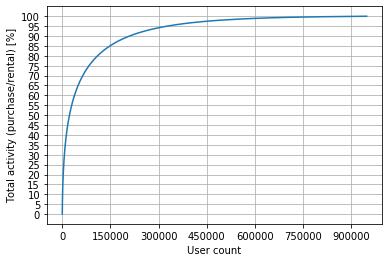

In [162]:
# Calculate how many users have watched X% of the content
idx = data_implicit['ID_USER'].value_counts().index.tolist()
counts = data_implicit['ID_USER'].value_counts().tolist()

user_count = []
percentage_activity = []
activity_so_far = 0
total_activity = sum(counts)

for u in range(len(idx)):
    
    user_count.append(u+1)
    
    activity_so_far = activity_so_far + counts[u]
    percentage_so_far = activity_so_far / total_activity * 100
    percentage_activity.append(percentage_so_far)
     
import matplotlib.pyplot as plt

plt.plot(user_count, percentage_activity)
plt.xlabel('User count')
plt.ylabel('Total activity (purchase/rental) [%]')
plt.grid()
plt.yticks(np.arange(0,105, 5))
plt.xticks(np.arange(0,1000000, 150000))
plt.show()